In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = r"D:\CVHackathon\archive\train"
test_dir = r"D:\CVHackathon\archive\test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model


In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (

In [9]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

with tf.device('/gpu:0'):
    history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])


Epoch 1/30
359/359 [==============================] - 597s 2s/step - loss: 9.1511 - accuracy: 0.3329 - val_loss: 5.3446 - val_accuracy: 0.2116
Epoch 2/30
359/359 [==============================] - 390s 1s/step - loss: 3.1729 - accuracy: 0.4867 - val_loss: 2.5705 - val_accuracy: 0.3588
Epoch 3/30
359/359 [==============================] - 387s 1s/step - loss: 1.7236 - accuracy: 0.5323 - val_loss: 1.4480 - val_accuracy: 0.5454
Epoch 4/30
359/359 [==============================] - 391s 1s/step - loss: 1.3484 - accuracy: 0.5577 - val_loss: 1.2516 - val_accuracy: 0.5807
Epoch 5/30
359/359 [==============================] - 396s 1s/step - loss: 1.2295 - accuracy: 0.5802 - val_loss: 1.4336 - val_accuracy: 0.4842
Epoch 6/30
359/359 [==============================] - 351s 979ms/step - loss: 1.1715 - accuracy: 0.5964 - val_loss: 1.4266 - val_accuracy: 0.5212
Epoch 7/30
359/359 [==============================] - 388s 1s/step - loss: 1.1437 - accuracy: 0.6086 - val_loss: 1.2667 - val_accuracy: 0.5

In [ ]:
history = pd.DataFrame(history.history)

In [10]:
model.save('emotion_epoch_30.h5')

In [12]:
model.layers[1].trainable = True

with tf.device('/gpu:0'):
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)


Epoch 1/20
359/359 [==============================] - 421s 1s/step - loss: 1.2008 - accuracy: 0.5974 - val_loss: 1.1956 - val_accuracy: 0.5924
Epoch 2/20
359/359 [==============================] - 464s 1s/step - loss: 1.1742 - accuracy: 0.6021 - val_loss: 1.1806 - val_accuracy: 0.5971
Epoch 3/20
359/359 [==============================] - 433s 1s/step - loss: 1.1593 - accuracy: 0.6127 - val_loss: 1.1720 - val_accuracy: 0.5982
Epoch 4/20
359/359 [==============================] - 634s 2s/step - loss: 1.1480 - accuracy: 0.6141 - val_loss: 1.1647 - val_accuracy: 0.6002
Epoch 5/20
359/359 [==============================] - 526s 1s/step - loss: 1.1393 - accuracy: 0.6176 - val_loss: 1.1614 - val_accuracy: 0.6011
Epoch 6/20
359/359 [==============================] - 454s 1s/step - loss: 1.1345 - accuracy: 0.6146 - val_loss: 1.1563 - val_accuracy: 0.6020
Epoch 7/20
359/359 [==============================] - 557s 2s/step - loss: 1.1303 - accuracy: 0.6210 - val_loss: 1.1522 - val_accuracy: 0.6025

AttributeError: 'History' object has no attribute 'append'

In [6]:
model.save('emotion_epoch_fine_tuned.h5')

NameError: name 'model' is not defined

In [13]:
model 

In [7]:
from tensorflow.keras.models import load_model

In [13]:
import numpy as np 

In [14]:
model = load_model(r"D:\CVHackathon\emotion_epoch_fine_tuned.h5")

In [15]:
import cv2 
img = cv2.imread(r"D:\CVHackathon\archive\test\angry\im7.png")
out = model(np.expand_dims(img , axis=0 ))

In [16]:
out 

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

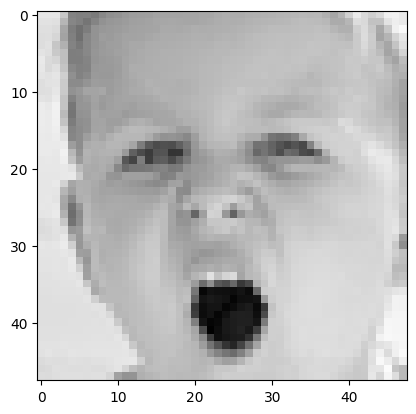

In [17]:
import matplotlib.pyplot as plt 
plt.imshow(img)

In [ ]:
out 

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

In [5]:
import numpy as np 

In [6]:
np.expand_dims(img , axis=0 ).shape

(1, 48, 48, 3)

In [9]:
import cv2 

cap = cv2.VideoCapture(0)


In [11]:
while True:

    ret , frame = cap.read()

    img = cv2.resize(frame, (48, 48))

    img = img.reshape(1 , 48 , 48 , 3)


    pred = model(img)

    print(pred)

    #frame = np.expand_dims(frame , axis = 0)


    org = (50, 50)

    image = cv2.putText(frame, str(pred), org,  cv2.FONT_HERSHEY_SIMPLEX , 3 , (255 , 0 , 0), 2, cv2.LINE_AA)

    cv2.imshow('frame' , image)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1. 0. 0.]], shape=(1, 7), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1